<a href="https://colab.research.google.com/github/willystumblr/AI-ML_Team_5/blob/kms/nlp/NLP_DT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#python basics
from matplotlib import pyplot as plt
import math, os, re, time, random, string
import numpy as np, pandas as pd, seaborn as sns

#this is just cool
from tqdm import tqdm

#visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')   #for optimum aesthetics 
import seaborn as sns

#natural language processing
from collections import defaultdict
import wordcloud

#ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')

In [12]:
test_df = pd.read_csv("./test.csv")
train_df = pd.read_csv("./train.csv")

# Data
## What should I expect the data format to be?
Each sample in the train and test set has the following information:

* The `text` of a tweet
* A `keyword` from that tweet (although this may be blank!)
* The `location` the tweet was sent from (may also be blank)

## What am I predicting?
You are predicting whether a given tweet is about a real disaster or not. If so, predict a `1`. If not, predict a `0`.


In [13]:
test_df.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [14]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Missing values

In [16]:
missing_val = pd.DataFrame(train_df.isnull().sum())
missing_val = missing_val.reset_index()
missing_val

,index,0
0,id,0
1,keyword,61
2,location,2533
3,text,0
4,target,0


In [17]:
#combine so we work smarter, not harder
total = train_df.append(test_df)

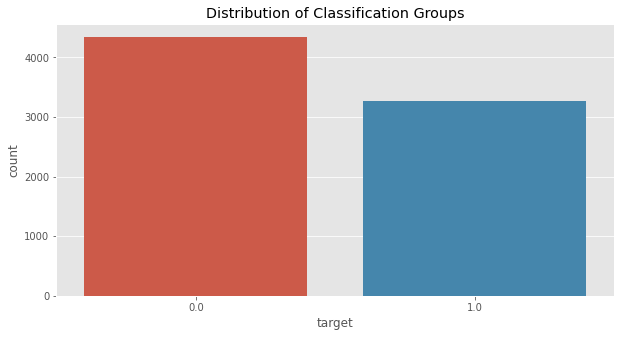

In [18]:
#set figure size
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
graph1 = sns.countplot(x = 'target', data = total)

#give title and plot
plt.title('Distribution of Classification Groups')
plt.show(graph1)

In [19]:
for df in [train_df, test_df]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [20]:
missing_val = pd.DataFrame(train_df.isnull().sum())
missing_val = missing_val.reset_index()
missing_val

,index,0
0,id,0
1,keyword,0
2,location,0
3,text,0
4,target,0


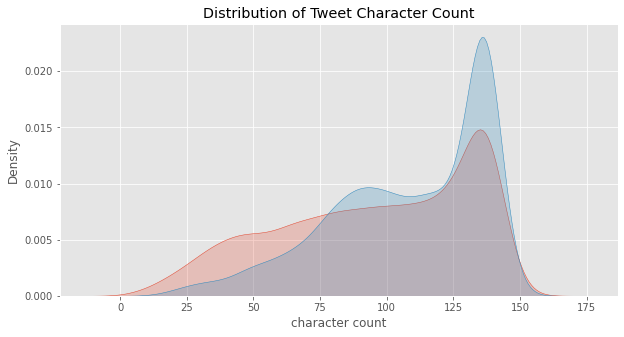

In [21]:
#create column for the number of characters in a tweet
total['character count'] = total['text'].apply(lambda x: len(x))

#split so we can use updated train set with new feature
train_df = total[:len(train_df)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train_df['character count'][train_df['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train_df['character count'][train_df['target'] == 1], shade = True, label = 'Disaster tweet')

#set title and plot
plt.title('Distribution of Tweet Character Count')
plt.show()

Very few disaster tweets are less than 50 characters and that the majority of them are more than 125 characters long.

In [22]:
#remove punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

#remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

#remove words less than 4 
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

#remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])

def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

In [23]:
strip_all_entities('As she gears up for the first night of her Las Vegas residency #PLAY, @katyperry chats with @zanelowe about her new collaboration with @Alesso, “When I’m Gone.”Listen now: http://apple.co/-nmd')

'As she gears up for the first night of her Las Vegas residency PLAY chats with about her new collaboration with When I m Gone Listen now'

### Number of unique values

In [9]:
unique_train_k = train_df['keyword'].nunique()
print(unique_train_k)

222


In [10]:
unique_train_l = train_df["location"].nunique()
unique_train_l

3342

## Meta Features
Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. **It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies.** Non-disaster tweets **have more typos than disaster tweets because they are coming from individual users**. 

The meta features used for the analysis are;

* `word_count`: number of words in text
* `url_count`: number of urls in text
* `mean_word_length`: average character count in words
* `char_count`: number of characters in text
* `punctuation_count`: number of punctuations in text
* `hashtag_count`: number of hashtags (#) in text
* `mention_count`: number of mentions (@) in text

In [12]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

import tokenize

In [13]:
import math, os, re, time, random, string

### Stopwords
Stopwords are the words in any language which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For some search engines, these are some of the most common, short function words, such as the, is, at, which, and on. In this case, stop words can cause problems when searching for phrases that include them, particularly in names such as “The Who” or “Take That”.

There is no hard and fast rule on when to remove stop words. **But I would suggest removing stop words if our task to be performed is one of Language Classification, Spam Filtering, Caption Generation, Auto-Tag Generation, Sentiment analysis, or something that is related to text classification.**

**Pros and Cons:**

One of the first things that we ask ourselves is what are the pros and cons of any task we perform. Let’s look at some of the pros and cons of stop word removal in NLP.


**pros:**
* Stop words are often removed from the text before training deep learning and machine learning models since stop words occur in abundance, hence providing little to no unique information that can be used for classification or clustering.
* On removing stopwords, dataset size decreases, and the time to train the model also decreases without a huge impact on the accuracy of the model.
* Stopword removal can potentially help in improving performance, as there are fewer and only significant tokens left. Thus, the classification accuracy could be improved


**cons:**
Improper selection and removal of stop words can change the meaning of our text. So we have to be careful in choosing our stop words.

In [15]:
from wordcloud import STOPWORDS

# stop_word_count
train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

In [24]:
from keras.preprocessing.text import Tokenizer

#find way to tokenize punctuation
to_exclude = '*+-/()%\n[\\]{|}^_`~\t'
to_tokenize = '!"#$&?:;<=>@'
tokenizer = Tokenizer(filters = to_exclude)
text = 'Why are you so f%#@ing angry all the time?!'
text = re.sub(r'(['+to_tokenize+'])', r' \1 ', text)
tokenizer.fit_on_texts([text])

#view new text
print(tokenizer.word_index)

{'why': 1, 'are': 2, 'you': 3, 'so': 4, 'f': 5, '#': 6, '@': 7, 'ing': 8, 'angry': 9, 'all': 10, 'the': 11, 'time': 12, '?': 13, '!': 14}


In [27]:
tweets = [tweet for tweet in total['text']]

#split data to update changes
train_df = total[:len(train_df)]
test_df = total[len(train_df):]

In [29]:
from keras.preprocessing.sequence import pad_sequences
from keras import Input

#define tokenizer options
tokenizer = Tokenizer()     
#tokenizer = Tokenizer(oov_token = '<OOV>')           #if you wanted to tokenized OOV words
#tokenizer = Tokenizer(filters = to_exclude)          #if you wanted to include punctuation
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)
labels = train_df['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

nlp_train = data[:len(train_df)]
labels = labels
nlp_test = data[len(train_df):]

MAX_SEQUENCE_LENGTH = data.shape[1]

Found 29319 unique tokens.
Shape of data tensor: (10876, 33)
Shape of label tensor: (7613,)


In [59]:
#get GloVe vector embeddings
embeddings_index = {}
with open("./glove.6B.200d.txt",'r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asfarray(values[1:])
        embeddings_index[word] = coefs
f.close()

print('\nFound %s word vectors in the GloVe library' % len(embeddings_index))


91361it [00:05, 16933.50it/s]


Found 91361 word vectors in the GloVe library


In [60]:
embedding_matrix = np.zeros((len(word_index) + 1, 200))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 29319/29319 [00:00<00:00, 508789.10it/s]

Our embedded matrix is of dimension (29320, 200)


In [61]:
#import neural network basic
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1, 200, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  

#we do not want embedding layer to train since it has been pretrained

In [62]:
#function to create lstm model
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)        
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [63]:
#define conveient training function to visualize learning curves
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [64]:
#create our first model
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 3e-4, bidirectional = True)
lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 33)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 33, 200)      5864000     ['nlp_input[0][0]']              
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 33, 200)     0           ['embedding_1[0][0]']            
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 200)          240800      ['spatial_dropout1d[0][0]']  

In [71]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale(df, scaler):
    return scaler.fit_transform(df.iloc[:, 2:])

#and scal
meta_train = scale(train_df, StandardScaler())
meta_test = scale(test_df, StandardScaler())

ValueError: ignored

ValueError: ignored